# g) Reporte de Desarrollo de machine learning para generación de modelos predictivos

el modelo en la parte inferior de esta libreta es un clasificador de thumbnails, se obtuvo una base de datos de thumbnails pública, la cual presenta un rango amplio de categorías de las cuales se tomó una muestra de creadores de contenido del canal, la forma en la que nosotros utilizamos esta base de datos fue para crear una red neuronal que pudiera generar un algoritmo predictivo de thumbnails, es decir, que la computadora pueda ver la imagen y definir el tipo de categoría a la que corresponde. 
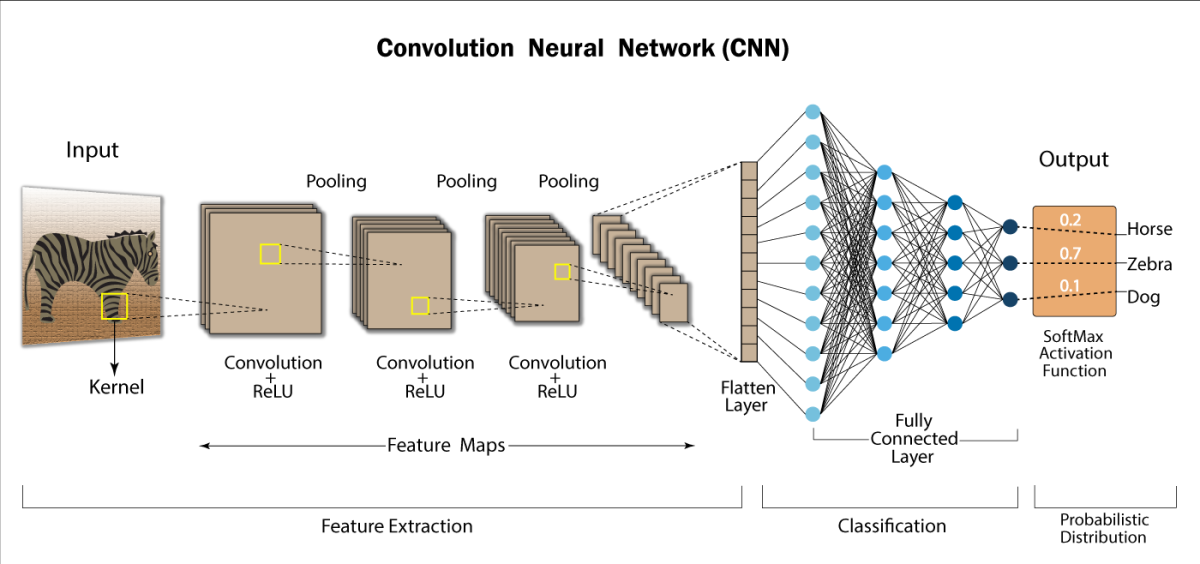


Una red neuronal convolucional es un tipo de red neuronal artificial donde las neuronas artificiales, corresponden a campos receptivos de una manera muy similar a las neuronas en la corteza visual primaria (V1) de un cerebro biológico. Este tipo de red es una variación de un perceptron multicapa, sin embargo, debido a que su aplicación es realizada en matrices bidimensionales, son muy efectivas para tareas de visión artificial, como en la clasificación y segmentación de imágenes, entre otras aplicaciones.


In [1]:
import numpy as np
import pandas as pd

import os
import shutil
import torch
import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm

from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Subset

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
data = pd.read_csv("C:\\Users\\qsavy_1\\CCD\\ccd_CNN\\archive\\thumbnails\\metadata.csv")
data

,Id,Channel,Category,Title
0,OkmNXy7er84,3Blue1Brown,Science,The hardest problem on the hardest test
1,r6sGWTCMz2k,3Blue1Brown,Science,But what is a Fourier series? From heat flow t...
2,bBC-nXj3Ng4,3Blue1Brown,Science,But how does bitcoin actually work?
3,aircAruvnKk,3Blue1Brown,Science,"But what is a neural network? | Chapter 1, Dee..."
4,HEfHFsfGXjs,3Blue1Brown,Science,The most unexpected answer to a counting puzzle
...,...,...,...,...
2510,In0nB0ABaUk,Web Dev Simplified,Tech,JavaScript Form Validation
2511,y17RuWkWdn8,Web Dev Simplified,Tech,Learn DOM Manipulation In 18 Minutes
2512,O6P86uwfdR0,Web Dev Simplified,Tech,Learn useState In 15 Minutes - React Hooks Exp...
2513,DUg2SWWK18I,Web Dev Simplified,Tech,MVC Explained in 4 Minutes


In [5]:
os.listdir('archive/thumbnails/images')

['Automobile',
 'Automobile,Comedy',
 'Blog',
 'Blog,Comedy',
 'Blog,Entertainment',
 'Blog,Science',
 'Bon App├⌐tit',
 'Comedy',
 'Comedy,Entertainment',
 'Comedy,Informative',
 'Entertainment',
 'Entertainment,Blog',
 'Entertainment,Comedy',
 'Food',
 'Food,Entertainment',
 'Informative',
 'Kurzgesagt ΓÇô In a Nutshell',
 'News',
 'Science',
 'Tech',
 'Tech,Comedy',
 'Tech,Informative',
 'Tech,News',
 'VideoGames']

### Arquitectura:
Las redes neuronales convolucionales consisten en múltiples capas de filtros convolucionales de una o más dimensiones. Después de cada capa, por lo general se añade una función para realizar un mapeo causal no-lineal.

Como redes de clasificación, al principio se encuentra la fase de extracción de características, compuesta de neuronas convolucionales y de reducción de muestreo. Al final de la red se encuentran neuronas de perceptron sencillas para realizar la clasificación final sobre las características extraídas. La fase de extracción de características se asemeja al proceso estimulante en las células de la corteza visual. Esta fase se compone de capas alternas de neuronas convolucionales y neuronas de reducción de muestreo. Según progresan los datos a lo largo de esta fase, se disminuye su dimensionalidad, siendo las neuronas en capas lejanas mucho menos sensibles a perturbaciones en los datos de entrada, pero al mismo tiempo siendo estas activadas por características cada vez más complejas.
Neuronas convolucionales
En la fase de extracción de características, las neuronas sencillas de un perceptron son reemplazadas por procesadores en matriz que realizan una operación sobre los datos de imagen 2D que pasan por ellas, en lugar de un único valor numérico. La salida de cada neurona convolucional se calcula como:

$${\displaystyle Y_{j}=g\left(b_{j}+\sum _{i}K_{ij}\otimes Y_{i}\right)}$$

Donde la salida $${\displaystyle Y_{j}}$$ de una neurona $${\displaystyle j}$$ es una matriz que se calcula por medio de la combinación lineal de las salidas $${\displaystyle Y_{i}}$$ de las neuronas en la capa anterior cada una de ellas operadas con el núcleo de convolucional $${\displaystyle K_{ij}}$$ correspondiente a esa conexión. Esta cantidad es sumada a una influencia $${\displaystyle b_{j}}$$ y luego se pasa por una función de activación $${\displaystyle g(\cdot )}$$ no-lineal.

El operador de convolución tiene el efecto de filtrar la imagen de entrada con un núcleo previamente entrenado. Esto transforma los datos de tal manera que ciertas características (determinadas por la forma del núcleo) se vuelven más dominantes en la imagen de salida al tener estas un valor numérico más alto asignados a los pixeles que las representan. Estos núcleos tienen habilidades de procesamiento de imágenes específicas, como por ejemplo la detección de bordes que se puede realizar con núcleos que resaltan la gradiente en una dirección en particular. Sin embargo, los núcleos que son entrenados por una red neuronal convolucional generalmente son más complejos para poder extraer otras características más abstractas y no triviales.

In [6]:
ch2cat = {}
cur_ch = ""
for i in data[['Channel', 'Category']].values.tolist():
    if i[0] == cur_ch: continue
    cur_ch = i[0]
    ch2cat[cur_ch] = i[1]

categories = set(val for val in ch2cat.values())

In [7]:
s = ""
for i in ch2cat.keys():
    if i == "Bon Appétit":
        s = i
        break
ch2cat["Bon Appetit"] = ch2cat[s]

In [8]:
basedir = "C:/Users/qsavy_1/CCD/ccd_CNN/archive/thumbnails/images/"

for fn in os.listdir(basedir):
    if fn not in ch2cat.keys(): continue
    try:
        os.rename(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))
    except OSError:
        shutil.move(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))

In [9]:
batch_size = 64

In [10]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# based on https://gist.github.com/srikarplus/8bdb5bedf0ca25e894e39ea78fce2f39
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                      normalize])

    train_transform = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                      normalize])

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir, transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )


    return (train_loader, valid_loader, train_dataset.class_to_idx)

In [11]:
train_loader, test_loader, class_idx = get_train_valid_loader("C:/Users/qsavy_1/CCD/ccd_CNN/archive/thumbnails/images/", batch_size, False, 42, 0.1)

In [12]:
class_idx

{'Automobile': 0,
 'Automobile,Comedy': 1,
 'Blog': 2,
 'Blog,Comedy': 3,
 'Blog,Entertainment': 4,
 'Blog,Science': 5,
 'Bon App├⌐tit': 6,
 'Comedy': 7,
 'Comedy,Entertainment': 8,
 'Comedy,Informative': 9,
 'Entertainment': 10,
 'Entertainment,Blog': 11,
 'Entertainment,Comedy': 12,
 'Food': 13,
 'Food,Entertainment': 14,
 'Informative': 15,
 'Kurzgesagt ΓÇô In a Nutshell': 16,
 'News': 17,
 'Science': 18,
 'Tech': 19,
 'Tech,Comedy': 20,
 'Tech,Informative': 21,
 'Tech,News': 22,
 'VideoGames': 23}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\qsavy_1\.conda\envs\torch_py\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


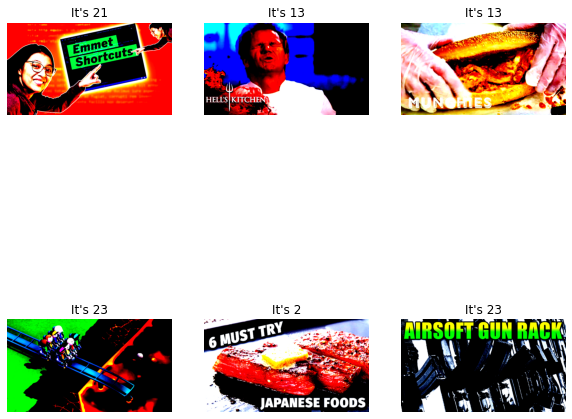

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for image, number in train_loader:
    for i in range(2):
        for j in range(3):
            ax[i, j].imshow(image[i * 3 + j].permute(1, 2, 0))
            ax[i, j].set_title(f'It\'s {number[i * 3 + j]}')
            ax[i, j].axis('off')
    break
fig.show()

In [14]:
# prepare model:
class Model(nn.Module):
    def __init__(self, out_features = 23):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(3, 16, 5, 3, 2),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512*3*7, 256*3*7),
            nn.ReLU(),
            nn.Linear(256*3*7, 128*3*7),
            nn.ReLU(),
            nn.Linear(128*3*7, out_features)
        )
    
    def forward(self, x):
        return self.blocks(x)


In [15]:
#!g1.1
model = Model(len(categories))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 100

In [16]:
model.to(device)

Model(
  (blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10752, out_features=5376, bias=True)
    (14): ReLU()
    (15): Linear(in_features=5376, out_features=2688, bias=True)
    (16): ReLU()
    (17): Linear(in_features=2688, out_features=22, bias=True)
  )
)

In [17]:
# train
from IPython.display import clear_output
def plot_loss_accuracy(train_losses, train_accs, test_accs, n):
    clear_output()
    fig, ax = plt.subplots(1, 2, figsize=(26,10))
    ax[0].set_title(f'Train Loss, epoch {n}')
    ax[0].plot(train_losses)
    ax[1].set_title('Accuracy')
    ax[1].plot(train_accs, label='Train')
    ax[1].plot(test_accs, label='Test')
    ax[1].legend()
    plt.grid()
    plt.show()

In [18]:
#!g1.1
def train_epoch(model, train_loader, criterion, optimizer, device='cpu',):
    model.train()
    train_losses = []
    train_accuracy = []

    for batch_X, batch_Y in tqdm(train_loader):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        optimizer.zero_grad()

        softmax = nn.Softmax()
        probs = softmax(model(batch_X))
        classes = torch.argmax(probs, dim=-1)
        loss = criterion(probs, batch_Y)

        loss.backward()

        train_losses.append(loss.item())
        train_accuracy.append((classes == batch_Y).float().mean().item())
        optimizer.step()
    
    return np.mean(train_losses), np.mean(train_accuracy)


def predict(model, test_loader, criterion, device='cpu'):
    model.eval()
    test_accuracy = []
    with torch.no_grad():
        for batch_X, batch_Y in tqdm(test_loader):
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            softmax = nn.Softmax()
            probs = softmax(model(batch_X))
            classes = torch.argmax(probs, dim=-1)
            
            test_accuracy.append((classes == batch_Y).float().mean().item())
    return np.mean(test_accuracy)


def train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device='cpu'):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        loss, accs = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(loss)
        train_accs.append(accs)
        test_accs.append(predict(model, test_loader, criterion, device))
        plot_loss_accuracy(train_losses, train_accs, test_accs, epoch)

# h) Reporte de Desarrollo de API para cada algoritmo desarrollado a través de inteligencia artificial:

El resultado predictivo de este modelo no cumplio los criterios para ser puesto en la página web ya que el modelo más optimizado que pudimos lograr tuvo una correlación del 33%, lo cual se lo atribuimos a 2 razones principales: la primera es que no contamos con una base de imágenes de thumbnails lo suficientemente robusta para que el modelo pueda encontrar una correlación adecuada y la segunda es por la tendencia actual de Youtube en cuanto a la estética de los thumbnails. El clima actual ha logrado que todas las categorías de los canales comparten un patrón similar. 

No obstante,  vamos a seguir incrementando nuestras bases de datos para poder mejorar nuestro modelo predictivo por categorías.

Es importante notar que la implementación de una red neuronal en áreas nuevas toma tiempo, siempre se pueden mejorar y modificar, esto es debido a que las predicciones son dependientes al tamaño de la muestra/


In [ ]:
import warnings
warnings.filterwarnings("ignore")
train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device)